# File to generate Nadir OSSE tracks 

In [1]:
import numpy as np 
import xarray as xr
import glob 
import os 
from scipy import interpolate
import random
import datetime

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import gc

from joblib import Parallel
from joblib import delayed as jb_delayed


## 1. - Functions  

In [2]:
def open_model_data(date):

    """
    This function opens the modelled ssh from the given date. 

    Returns the dataset containing the modelled ssh and the interpolator.
    """

    dir_input_ssh = "/bettik/bellemva/MITgcm/MITgcm_filtered_final"

    path = os.path.join(dir_input_ssh,"MITgcm_filt_"+date.astype('str').replace("-","")+"*.nc")

    ds_ssh = xr.open_mfdataset(path,combine='nested',concat_dim="time")

    time_array_float = np.array([t.astype("datetime64[s]").astype('float64') for t in ds_ssh.time.values])
    ds_ssh = ds_ssh.assign_coords({"time":time_array_float})

    finterp = interpolate.RegularGridInterpolator([ds_ssh.time.values,ds_ssh.latitude.values,ds_ssh.longitude.values],
                                              ds_ssh.ssh_cor.values,
                                              bounds_error=False)
    
    return ds_ssh, finterp 

In [3]:
def interp_satellite(latitude_data_array,longitude_data_array,time_data_array,time_serie,interp):
    """
    This function interpolates the modelled ssh on the provided swaths (for SWOT satellite). 

        - latitude_data_array : data array containing the latitude information of each pixel (shape = [num_lines,num_pixels])
        - longitude_data_array : data array containing the longitude information of each pixel (shape = [num_lines,num_pixels])
        - time_data_array : data array containing the time information of each pixel (shape = [num_lines,num_pixels])
        - time_serie : initial time_array of the observations (before converting to float)
        - interp : interpolator as provided by the function open_model_data

    Returns : 
        - ds : dataset of interpolated ssh. Longitude and latitude are coodinates indexed by [num_lines,num_pixels]. Time and ssh_cor are variables. 

    """
        


    ssh_interp = interp(np.transpose([time_data_array, latitude_data_array,longitude_data_array]))

    ds = xr.Dataset({'time':(('num_lines'),time_serie),
                     'ssh_cor':(['num_lines','num_pixels'],ssh_interp.T),}, 
                    coords={'latitude':(['num_lines','num_pixels'],latitude_data_array.values),
                            'longitude':(['num_lines','num_pixels'],longitude_data_array.values)} 
                    )
    
    return ds 


## 2. - Data loading 

The information of SWOT swaths coordinates are dowloaded.

In [ ]:
ds = xr.open_dataset("/bettik/bellemva/satellite_track/swot/track_swot.nc")

The indexes of the lines that are contained around the CCS Cal/Val (lon : [215;245] ; lat : [15;45]) are 71300:73500 (descending phase, blue) and 183050:185200 (ascending phase, red) - as shown on the next plot.

In [ ]:
fig, ax = plt.subplots(figsize=(9,4),dpi=200,subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0.)})

ax.set_extent([-180, -115,10, 45],crs=ccrs.PlateCarree())
map_ssh = ax.scatter(ds.longitude[71300:73500,1].values,
            ds.latitude[71300:73500,1].values,
            c="blue"
            )
ax.set_extent([-180, -115,10, 45],crs=ccrs.PlateCarree())
map_ssh = ax.scatter(ds.longitude[183050:185200,1].values,
            ssh.latitude[183050:185200,1].values,
            c="red"
            )

ax.add_feature(cfeature.LAND,color="lightgrey",zorder=1)
ax.add_feature(cfeature.OCEAN,color="black",zorder=0)
ax.coastlines(lw=0.5)
ax.set_aspect("equal")
ax.set_title("Modelled Sea Surface Height (SSH)")

gridlines = ax.gridlines(
    alpha=0.3,
    color="white",
    draw_labels=True,
    xlocs=np.arange(-180,-115,10),
    ylocs=np.arange(10,45,5),
    # xformatter=cartopy.mpl.ticker.LongitudeFormatter(zero_direction_label=True,),
)
gridlines.right_labels = False
gridlines.top_labels  = False
gridlines.xlabel_style = {'size': 11}
gridlines.ylabel_style = {'size': 11}
ax.set_aspect("equal")


The next cell selects the poinst conatined in the CCS Cal/Val site. The indexes are the one defined above.

In [ ]:
lines_ccs_desc = xr.DataArray(np.concatenate([np.arange(71300,73500)]), dims="num_lines")
lines_ccs_asc = xr.DataArray(np.concatenate([np.arange(183050,185200)]), dims="num_lines")

ds_ccs_desc = ds.isel(num_lines=lines_ccs_desc).load()
ds_ccs_asc = ds.isel(num_lines=lines_ccs_asc).load()

ds_ccs = xr.concat([ds_ccs_desc,ds_ccs_asc],dim = "num_lines").load()

ds_ccs

## 2. - Track interpolating

This loop on dates calls the function **interp_satellite** for modelled data and CCS SOWT Cal/Val data. 

In [ ]:
dates = np.arange(np.datetime64("2012-05-01"),np.datetime64("2012-08-01"))

for d in dates: 

    ds_ssh, finterp = open_model_data(d)

    # delta_time corresponds to the time difference in days between the date of the ds_ccs and date d 
    delta_time = (np.datetime64("2023-01-21")-d).astype(int)

    ### this block creates an object of type DataArray that has the shape of [num_lines, num_pixels] ###
    time_array = ds_ccs.time.values-np.timedelta64(delta_time,"D")
    new_time_array = np.array([np.datetime64(t.astype('str').replace("2019","2012")).astype('datetime64[s]') for t in time_array])
    new_time_array_float = np.array([t.astype('float64') for t in new_time_array])
    time_data_array = ds_ccs.assign(time=("num_lines",new_time_array_float)).time.expand_dims(dim={"num_pixels":69},axis=1)
    #####################################################################################################
    
    ds = interp_satellite(latitude_data_array = ds_ccs.latitude,longitude_data_array = ds_ccs.longitude,time_data_array = time_data_array,time_serie = time_array,interp = finterp)

    # Saves the observation 
    ds.to_netcdf("/bettik/bellemva/2022a_CCS_CalVal/swot/ds_swot_"+d.astype('str').replace("-","")+".nc")
    
    del ds, ds_ssh, finterp, time_array
    gc.collect()
    
    print(d,"done")


## 3. - Plots 

In [4]:
def map_ssh(ssh,mask,ax,vmin,vmax): 
    """
    This function plots the data of Nadirs. 
    """
    return ax.scatter(ssh.longitude.values[mask],
            ssh.latitude.values[mask],
            c=ssh.ssh_cor.values[mask],
            cmap="Spectral",
            s=0.1,
            vmin = vmin,
            vmax = vmax
            )

In [5]:
def map_ssh_swot(ssh,ax,vmin,vmax):
    """
    This function plots the data of SWOT. 
    """
    return ax.scatter(ssh.longitude.values,
            ssh.latitude.values,
            c=ssh.ssh_cor.values,
            cmap="Spectral",
            s=0.1,
            vmin = vmin,
            vmax = vmax
            )

In [6]:

def plot(ssh_alg,ssh_j3,ssh_s3a,ssh_s3b,ssh_c2,ssh_swot,
         mask_alg,mask_j3,mask_s3a,mask_s3b,mask_c2,date): 
    
    """
    This function creates the plots of the modelled satellite tracks for a given date. 

    Input : 
        - ssh_alg, ssh_j3,ssh_s3a,ssh_s3b,ssh_c2,ssh_swot : datasets of interpolated ssh 
        - mask_alg,mask_j3,mask_s3a,mask_s3b,mask_c2 : mask containing True when the point is measured at time corresponding to date input parameter 
        - date 

    Returns : None (but saves output)
    
    """
    

    fig, ax = plt.subplots(figsize=(9,4),dpi=200,subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0.)})

    ax.set_extent([-145, -115,15, 45],crs=ccrs.PlateCarree())
    vmin=-1
    vmax=1

    for ssh,mask in zip((ssh_alg,ssh_j3,ssh_s3a,ssh_s3b,ssh_c2),
                        (mask_alg,mask_j3,mask_s3a,mask_s3b,mask_c2)):
        if mask.sum()>0:

            map_ssh(ssh,mask,ax,vmin=vmin,vmax=vmax)

    if ssh_swot is not None : 
        map_swot = map_ssh_swot(ssh_swot,ax,vmin=vmin,vmax=vmax)


    ax.add_feature(cfeature.LAND,color="lightgrey",zorder=1)
    ax.add_feature(cfeature.OCEAN,color="black",zorder=0)
    ax.coastlines(lw=0.5)
    ax.set_aspect("equal")
    ax.set_title("SSH Observations")

    gridlines = ax.gridlines(
        alpha=0.3,
        color="white",
        draw_labels=True,
        xlocs=np.arange(-180,-115,10),
        ylocs=np.arange(10,45,5),
        # xformatter=cartopy.mpl.ticker.LongitudeFormatter(zero_direction_label=True,),
    )
    gridlines.right_labels = False
    gridlines.top_labels  = False
    gridlines.xlabel_style = {'size': 11}
    gridlines.ylabel_style = {'size': 11}
    ax.set_aspect("equal")

    #cbar = plt.colorbar(mappable=map_swot)
    #cbar.set_label("SSH")

    ax.text(s=date.astype('str'),x=-123.5,y=44,c="black",fontsize=8)

    plt.savefig("/home/bellemva/CCS/data/interp_satellite_track/frames/"+date.astype("str")+".png")


In [ ]:
time_array = np.arange(np.datetime64("2012-06-01"),np.datetime64("2012-06-14"))

for d in time_array : 
    # Imports the datasets of SSH 
    ds_alg = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/dc_nadir/alg/ds_alg_"+d.astype("str").replace("-","")+".nc")
    ds_s3a = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/dc_nadir/s3a/ds_s3a_"+d.astype("str").replace("-","")+".nc")
    ds_s3b = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/dc_nadir/s3b/ds_s3b_"+d.astype("str").replace("-","")+".nc")
    ds_c2 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/dc_nadir/c2/ds_c2_"+d.astype("str").replace("-","")+".nc")
    ds_j3 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/dc_nadir/j3/ds_j3_"+d.astype("str").replace("-","")+".nc")
    ds_swot = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/dc_swot/ds_swot_"+d.astype("str").replace("-","")+".nc")

    for i in range (24):
        time = d+np.timedelta64(i,"h")
        # Creates the mask selecting data for one given date 
        mask_alg = ds_alg.time.astype('datetime64[h]')==time
        mask_s3a = ds_s3a.time.astype('datetime64[h]')==time
        mask_s3b = ds_s3b.time.astype('datetime64[h]')==time
        mask_c2 = ds_c2.time.astype('datetime64[h]')==time
        mask_j3 = ds_j3.time.astype('datetime64[h]')==time

        # Creates the SWOT ssh dataset 

        if i==6 : 
            ds_swot_selec = ds_swot.isel(num_lines = slice(0,2200))
        elif i==23 : 
            ds_swot_selec =ds_swot.isel(num_lines = slice(2200,4350))
        else : 
            ds_swot_selec=None 

        plot(ssh_alg=ds_alg,ssh_j3=ds_j3,ssh_s3a=ds_s3a,ssh_s3b=ds_s3b,ssh_c2 = ds_c2,ssh_swot=ds_swot_selec,
             mask_alg=mask_alg,mask_j3=mask_j3,mask_s3a=mask_s3a,mask_s3b=mask_s3b,mask_c2=mask_c2,date=time)    
        

    

In [ ]:
dates = np.arange(np.datetime64("2012-05-01"),np.datetime64("2012-06-01"))

# deleting the content of file.sh 
file = open("/home/bellemva/CCS/data/interp_satellite_track/file.sh","w")
file.close()

for d in dates:

    command = "ncap2 -A -s \"ssh_10=ssh_cor*0+10\" "

    command += "/bettik/bellemva/2022a_CCS_CalVal/dc_swot/ds_swot_"+d.astype('str').replace("-","")+".nc "

    command += "/bettik/bellemva/2022a_CCS_CalVal/dc_swot/ds_swot_"+d.astype('str').replace("-","")+".nc \n"

    file = open("/home/bellemva/CCS/data/interp_satellite_track/file.sh","a")
    
    file.write(command)

    file.close()

In [ ]:
ds_alg

In [ ]:
ds_alg = xr.open_mfdataset(["/bettik/bellemva/2022a_CCS_CalVal/dc_nadir/alg/ds_alg_20120604.nc",
                            "/bettik/bellemva/2022a_CCS_CalVal/dc_nadir/alg/ds_alg_20120605.nc"],combine='nested',concat_dim='time')

### Plot for Liège poster

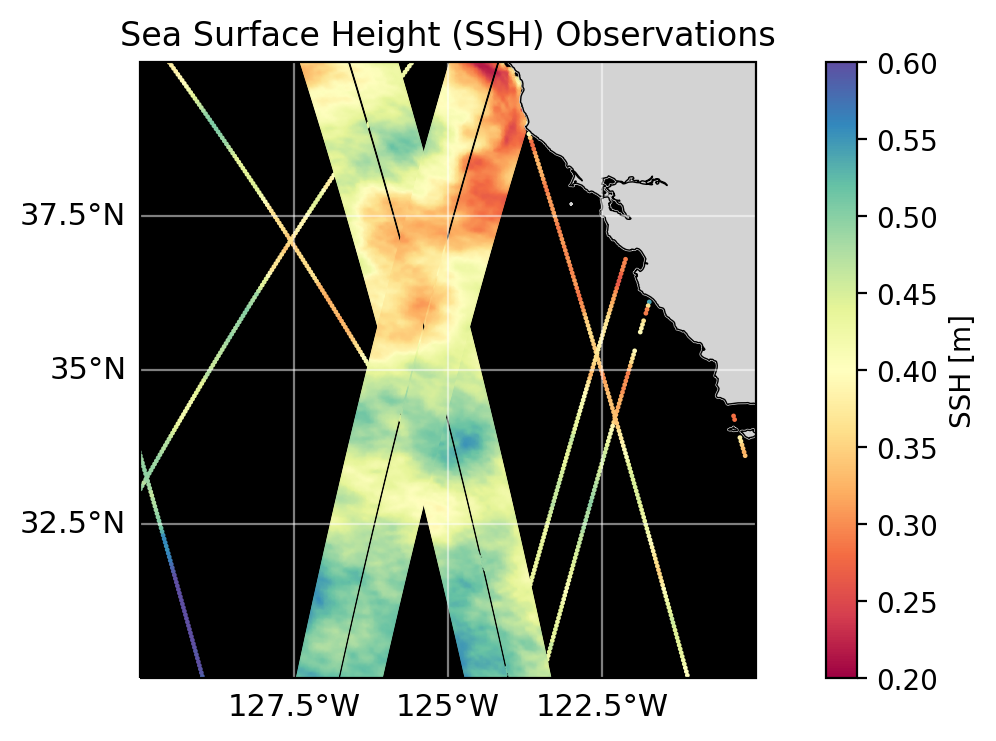

In [7]:
#ds_alg = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/alg/ds_alg_20120604.nc")
ds_alg2 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/alg/ds_alg_20120603.nc")

#ds_s3a = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/s3a/ds_s3a_20120604.nc")
ds_s3a2 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/s3a/ds_s3a_20120603.nc")

#ds_s3b = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/s3b/ds_s3b_20120604.nc")
ds_s3b2 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/s3b/ds_s3b_20120603.nc")

#ds_c2 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/c2/ds_c2_20120604.nc")
ds_c22 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/c2/ds_c2_20120603.nc")

#ds_j3 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/j3/ds_j3_20120604.nc")
ds_j32 = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/nadir/j3/ds_j3_20120603.nc")

ds_swot = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/swot/ds_swot_20120603.nc")

fig, ax = plt.subplots(figsize=(9,4),dpi=200,subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0.)})

ax.set_extent([-130, -120,30, 40],crs=ccrs.PlateCarree())
vmin=0.2
vmax=0.6

#for ssh in (ds_alg,ds_alg2,ds_j3,ds_j32,ds_s3a,ds_s3a2,ds_s3b,ds_s3b2,ds_c2,ds_c22):
for ssh in (ds_alg2,ds_j32,ds_s3a2,ds_s3b2,ds_c22):
    #mask = np.ones(len(ssh.longitude.values),dtype='int')
    #map_ssh(ssh,mask,ax,vmin=vmin,vmax=vmax)

    ax.scatter(ssh.longitude.values,
           ssh.latitude.values,
           c=ssh.ssh_cor.values,
            cmap="Spectral",
            s=0.5,
            vmin = vmin,
            vmax = vmax
            )


map_swot = map_ssh_swot(ds_swot,ax,vmin=vmin,vmax=vmax)

ax.add_feature(cfeature.LAND,color="lightgrey",zorder=1)
ax.add_feature(cfeature.OCEAN,color="black",zorder=0)
ax.coastlines(lw=0.5)
ax.set_aspect("equal")
ax.set_title("Sea Surface Height (SSH) Observations")

gridlines = ax.gridlines(
    alpha=0.5,
    color="white",
    draw_labels=True,
    xlocs=np.arange(-180,-115,2.5),
    ylocs=np.arange(10,45,2.5),
    # xformatter=cartopy.mpl.ticker.LongitudeFormatter(zero_direction_label=True,),
)
gridlines.right_labels = False
gridlines.top_labels  = False
gridlines.xlabel_style = {'size': 11}
gridlines.ylabel_style = {'size': 11}
ax.set_aspect("equal")

cbar = plt.colorbar(mappable=map_swot,)
cbar.set_label("SSH [m]")

#ax.text(s=date.astype('str'),x=-123.5,y=44,c="black",fontsize=8)

# plt.savefig("/home/bellemva/CCS/data/interp_satellite_track/frames/"+date.astype("str")+".png")

In [ ]:
plt.hist(ds_swot.ssh_cor.values.flatten())

## 4. - Formatting 

This cell aims at formatting the SWOT data prior to its interpolation. During interpolation phase, gap between two swaths hasn't been masked by NaNs. This processing step will mask the data around Nadir according tot the mask on SWOT real Data. 

In [ ]:
ds_swot = xr.open_dataset("/bettik/bellemva/2022a_CCS_CalVal/swot/ds_swot_20120603.nc")

In [ ]:
# mask of measured values, taken from SWOT real data 
mask_line = np.array([ True,  True, False, False, False, False, False, False, False,False, False, False, False, False, False, False, False, False,False, False, False, False, False, False, False, False, False,False, False, False, False, False, False,  True,  True,  True,False, False, False, False, False, False, False, False, False,False, False, False, False, False, False, False, False, False,False, False, False, False, False, False, False, False, False,False, False, False, False,  True,  True])
# transfering it into 2d data array 
mask_array = np.repeat(np.expand_dims(mask_line,axis=0),axis=0,repeats=ds_swot.dims['num_lines'])

In [ ]:
# function to save the masked data for a given date 
def save_masked_data(name_file,mask_array):
    ds_swot = xr.open_dataset(name_file)
    ds_swot.ssh_cor.values[mask_array]=np.nan
    ds_swot.to_netcdf(name_file.replace("swot/","swot_bis/"))

In [ ]:
# list of filenames 
list_file = !ls /bettik/bellemva/2022a_CCS_CalVal/swot/ds*.nc

In [ ]:
# parallel computing
res = np.array(Parallel(n_jobs=6,backend='multiprocessing')(jb_delayed(save_masked_data)(list_file[i],mask_array) for i in range(len(list_file))))